# **1. Perkenalan Dataset**

Dataset yang akan digunakan adalah Dataset Fruit and Vegetable Disease (Healthy vs Rotten) yang berisi 14 jenis buah-buahan yang mana masing-masingnya memiliki 2 class yaitu baik atau busuk, dengan total class yaitu sebanyak 28 dengan total semua gambar berjumlah 29,291.
https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten

Karena dataset merupakan gabungan dari gambar yang telah diaugmentasi dan yang belum oleh pemilik dataset dan karena kebetulan gambar yang di augmentasi dinamakan sesuai dengan augmentasinya juga, maka pada data cleaning akan dibuat kode untuk menghapus gambar augmentasi dari dataset, karena pada proyek ini akan dilakukan augmentasi sendiri jadi akan digunakan gambar yang belum diaugmentasi.

Untuk jumlah class yang digunakan yaitu sebanyak 8 class saja jadi total 4 buah yaitu Banana, Mango, Potato, Strawberry yang mana masing-masing terbagi menjadi 2 class yaitu baik dan busuk jadi total ada 8 class, total gambar yang akan digunakan dari dataset berjumlah 10,256.

Proyek ini dibuat dengan tujuan membuat sistem klasifikasi gambar untuk mendeteksi apakah suatu buah itu masih layak konsumsi atau sudah tidak layak yaitu sudah busuk.

# **2. Import Library**

In [ ]:
!pip install tensorflowjs

In [86]:
import os
import shutil
import zipfile
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
from collections import defaultdict
from google.colab import drive

from tensorflow.keras.applications import MobileNetV2
from collections import defaultdict
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# **3. Memuat and Extract Dataset**
Memuat dataset yang telah di download dari kaggle dan disimpan ke drive lalu mengcopynya ke google colab kemudian meng-extractnya

In [6]:
#Menghubungkan ke drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/MyDrive/Dicoding_BPML_Klasifikasi Gambar_Muhammad Raihan Fauzi/archive.zip'

#Mengcopy data dari dataset yang telah tersimpan di drive ke penyimpanan colab
shutil.copy(drive_path, '/content/archive.zip')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/archive.zip'

In [7]:
dataset_path = '/content/'

#Extract zip
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print(f"Berhasil di-ekstrak ke: {dataset_path}")

Berhasil di-ekstrak ke: /content/


#**4. Data Cleaning dan Visualization**#
Karena pada dataset yang digunakan merupakan gabungan dari gambar yang telah di augmentasi dan tidak, karena pada dataset ini gambar augmentasi dinamakan sesuai augmentasinya oleh pemilik dataset maka akan dibuat code untuk menghapus gambar yang telah di augmentasi.

Untuk mengurangi jumlah gambar akan dihapus beberapa class, jadi akan hanya menggunakan 8 kelas yang terdiri dari 4 buah dengan class busuk dan baik.

In [8]:
data_dir = pathlib.Path(dataset_path + '/Fruit And Vegetable Diseases Dataset')
class_names = sorted([item.name for item in data_dir.glob("*") if item.is_dir()])
# Hitung jumlah gambar per kelas
class_counts = defaultdict(int)
for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_folder))
# Total Jumlah Gambar Keseluruhan
total_images = sum(class_counts.values())
print(f"Total jumlah gambar sebelum di bersihkan: {total_images}")

Total jumlah gambar sebelum di bersihkan: 29291


In [9]:
# Print jumlah gambar per kelas sebelum dibersihkan
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

Apple__Healthy: 2438 gambar
Apple__Rotten: 2930 gambar
Banana__Healthy: 2000 gambar
Banana__Rotten: 2800 gambar
Bellpepper__Healthy: 611 gambar
Bellpepper__Rotten: 591 gambar
Carrot__Healthy: 620 gambar
Carrot__Rotten: 580 gambar
Cucumber__Healthy: 608 gambar
Cucumber__Rotten: 593 gambar
Grape__Healthy: 200 gambar
Grape__Rotten: 200 gambar
Guava__Healthy: 200 gambar
Guava__Rotten: 200 gambar
Jujube__Healthy: 200 gambar
Jujube__Rotten: 200 gambar
Mango__Healthy: 1813 gambar
Mango__Rotten: 2247 gambar
Orange__Healthy: 2075 gambar
Orange__Rotten: 2186 gambar
Pomegranate__Healthy: 200 gambar
Pomegranate__Rotten: 200 gambar
Potato__Healthy: 615 gambar
Potato__Rotten: 585 gambar
Strawberry__Healthy: 1603 gambar
Strawberry__Rotten: 1596 gambar
Tomato__Healthy: 604 gambar
Tomato__Rotten: 596 gambar


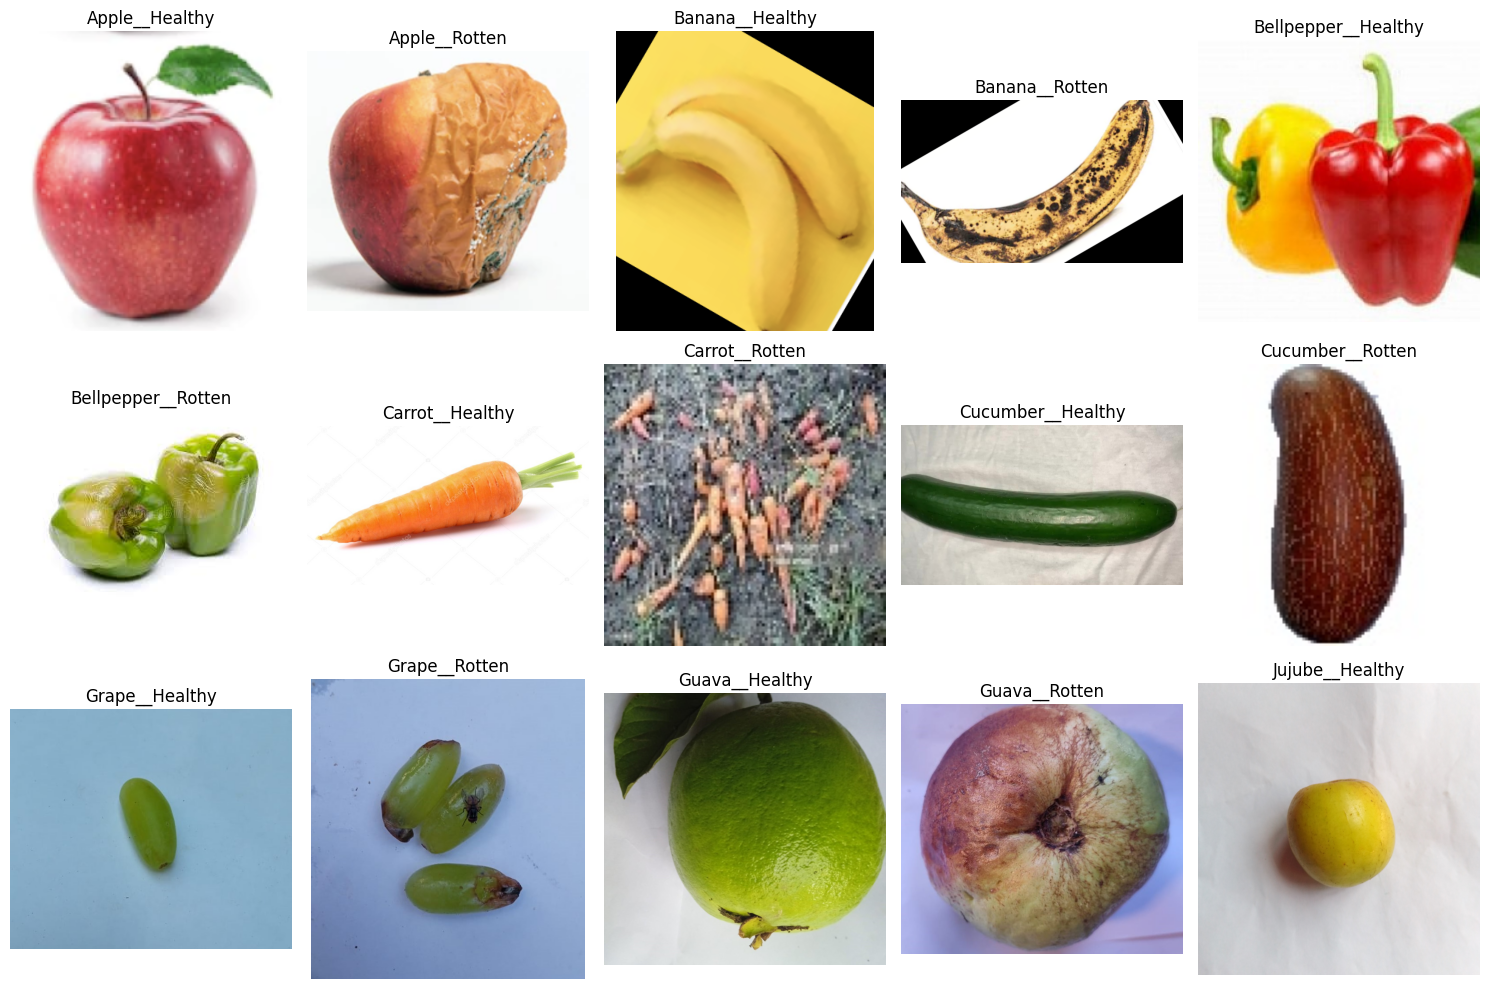

In [10]:
# Visualisasi 1 gambar dari masing-masing kelas sebelum gambar augmentasi dari dataset dihapus
plt.figure(figsize=(15, 10))
for idx, class_name in enumerate(class_names[:15]):
    class_folder = os.path.join(data_dir, class_name)
    img_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    img = tf.keras.utils.load_img(img_path)
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
# Menghapus gambar augmentasi, gambar augmentasi yang ingin dihapus berawalan 'vertical_flip_', 'translation_', 'saltandpepper_', 'rotated_by_'
prefixes = ['vertical_flip_', 'translation_', 'saltandpepper_', 'rotated_by_']

# Loop semua folder kelas
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        print(f"Checking in class: {class_dir.name}")

        for file_name in os.listdir(class_dir):
            file_path = class_dir / file_name
            if file_path.is_file():
                # Cek apakah nama file dimulai dengan salah satu prefix augmentasi
                if any(file_name.startswith(prefix) for prefix in prefixes):
                    try:
                        os.remove(file_path)
                        print(f"Deleted: {file_path}")
                    except Exception as e:
                        print(f"Error deleting {file_path}: {e}")

Output streaming akan dipotong hingga 5000 baris terakhir.
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/rotated_by_45_Screen Shot 2018-06-13 at 12.10.27 AM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/translation_Screen Shot 2018-06-13 at 12.13.35 AM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/rotated_by_30_Screen Shot 2018-06-12 at 11.58.02 PM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/rotated_by_45_Screen Shot 2018-06-12 at 11.59.33 PM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/vertical_flip_Screen Shot 2018-06-13 at 12.01.23 AM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/vertical_flip_Screen Shot 2018-06-12 at 11.56.35 PM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset/Orange__Healthy/rotated_by_45_Screen Shot 2018-06-13 at 12.16.22 AM.png
Deleted: /content/Fruit And Vegetable Diseases Dataset

In [12]:
# Rename folder dengan mengganti "__" menjadi " "
for class_dir in data_dir.iterdir():
    if class_dir.is_dir() and "__" in class_dir.name:
        new_name = class_dir.name.replace("__", " ")
        new_path = data_dir / new_name
        try:
            class_dir.rename(new_path)
            print(f"Renamed: {class_dir.name} ➜ {new_name}")
        except Exception as e:
            print(f"Error renaming {class_dir.name}: {e}")

Renamed: Tomato__Rotten ➜ Tomato Rotten
Renamed: Pomegranate__Healthy ➜ Pomegranate Healthy
Renamed: Strawberry__Healthy ➜ Strawberry Healthy
Renamed: Carrot__Healthy ➜ Carrot Healthy
Renamed: Banana__Rotten ➜ Banana Rotten
Renamed: Guava__Healthy ➜ Guava Healthy
Renamed: Guava__Rotten ➜ Guava Rotten
Renamed: Pomegranate__Rotten ➜ Pomegranate Rotten
Renamed: Potato__Healthy ➜ Potato Healthy
Renamed: Grape__Healthy ➜ Grape Healthy
Renamed: Jujube__Rotten ➜ Jujube Rotten
Renamed: Carrot__Rotten ➜ Carrot Rotten
Renamed: Mango__Rotten ➜ Mango Rotten
Renamed: Orange__Rotten ➜ Orange Rotten
Renamed: Orange__Healthy ➜ Orange Healthy
Renamed: Potato__Rotten ➜ Potato Rotten
Renamed: Cucumber__Healthy ➜ Cucumber Healthy
Renamed: Banana__Healthy ➜ Banana Healthy
Renamed: Bellpepper__Rotten ➜ Bellpepper Rotten
Renamed: Bellpepper__Healthy ➜ Bellpepper Healthy
Renamed: Jujube__Healthy ➜ Jujube Healthy
Renamed: Strawberry__Rotten ➜ Strawberry Rotten
Renamed: Cucumber__Rotten ➜ Cucumber Rotten
Rename

In [13]:
# Daftar kelas yang akan dihapus agar mendekati 10.000 gambar, karena saat ini masih 29.291 gambar
classes_to_remove = [
    'Grape Healthy',
    'Grape Rotten',
    'Guava Healthy',
    'Guava Rotten',
    'Jujube Healthy',
    'Jujube Rotten',
    'Pomegranate Healthy',
    'Pomegranate Rotten',
    'Tomato Healthy',
    'Tomato Rotten',
    'Cucumber Healthy',
    'Cucumber Rotten',
    'Bellpepper Healthy',
    'Bellpepper Rotten',
    'Orange Healthy',
    'Orange Rotten',
    'Apple Healthy',
    'Apple Rotten',
    'Carrot Healthy',
    'Carrot Rotten'
]

# Hapus folder kelas yang tidak diinginkan
for class_name in classes_to_remove:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)
        print(f"Deleted class: {class_name}")
    else:
        print(f"Class {class_name} not found")

# Update daftar kelas setelah penghapusan
class_names = sorted([
    item.name for item in data_dir.glob("*")
    if item.is_dir() and item.name not in classes_to_remove
])

print("\nUpdated classes after removal:")
print(class_names)

Deleted class: Grape Healthy
Deleted class: Grape Rotten
Deleted class: Guava Healthy
Deleted class: Guava Rotten
Deleted class: Jujube Healthy
Deleted class: Jujube Rotten
Deleted class: Pomegranate Healthy
Deleted class: Pomegranate Rotten
Deleted class: Tomato Healthy
Deleted class: Tomato Rotten
Deleted class: Cucumber Healthy
Deleted class: Cucumber Rotten
Deleted class: Bellpepper Healthy
Deleted class: Bellpepper Rotten
Deleted class: Orange Healthy
Deleted class: Orange Rotten
Deleted class: Apple Healthy
Deleted class: Apple Rotten
Deleted class: Carrot Healthy
Deleted class: Carrot Rotten

Updated classes after removal:
['Banana Healthy', 'Banana Rotten', 'Mango Healthy', 'Mango Rotten', 'Potato Healthy', 'Potato Rotten', 'Strawberry Healthy', 'Strawberry Rotten']


In [14]:
for cls in classes_to_remove:
    path = data_dir / cls
    if path.exists(): shutil.rmtree(path)

# Hitung ulang nama kelas & jumlah gambar
class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
class_counts = {}
for cls in class_names:
    folder = data_dir / cls
    # hanya hitung file
    class_counts[cls] = sum(1 for f in os.listdir(folder) if (folder/f).is_file())

# Print hasil
print("Classes after cleaning:", class_names)
for cls, cnt in class_counts.items():
    print(f"{cls}: {cnt} gambar")
print("\nTotal gambar:", sum(class_counts.values()))

Classes after cleaning: ['Banana Healthy', 'Banana Rotten', 'Mango Healthy', 'Mango Rotten', 'Potato Healthy', 'Potato Rotten', 'Strawberry Healthy', 'Strawberry Rotten']
Banana Healthy: 983 gambar
Banana Rotten: 814 gambar
Mango Healthy: 1813 gambar
Mango Rotten: 2247 gambar
Potato Healthy: 615 gambar
Potato Rotten: 585 gambar
Strawberry Healthy: 1603 gambar
Strawberry Rotten: 1596 gambar

Total gambar: 10256


In [15]:
# === Total Jumlah Gambar Keseluruhan ===
total_images = sum(class_counts.values())
print(f"Total jumlah gambar setelah penggabungan: {total_images}")

Total jumlah gambar setelah penggabungan: 10256


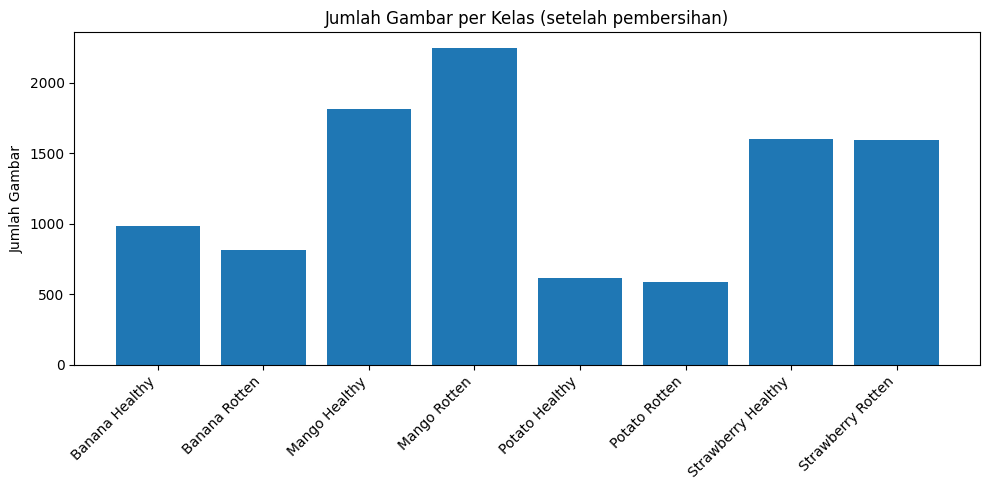

In [16]:
# === Visualisasi Jumlah Gambar Tiap Kelas Dengan Bar Chart ===
# Visualisasi bar chart
plt.figure(figsize=(10,5))
plt.bar(class_names, class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title("Jumlah Gambar per Kelas (setelah pembersihan)")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

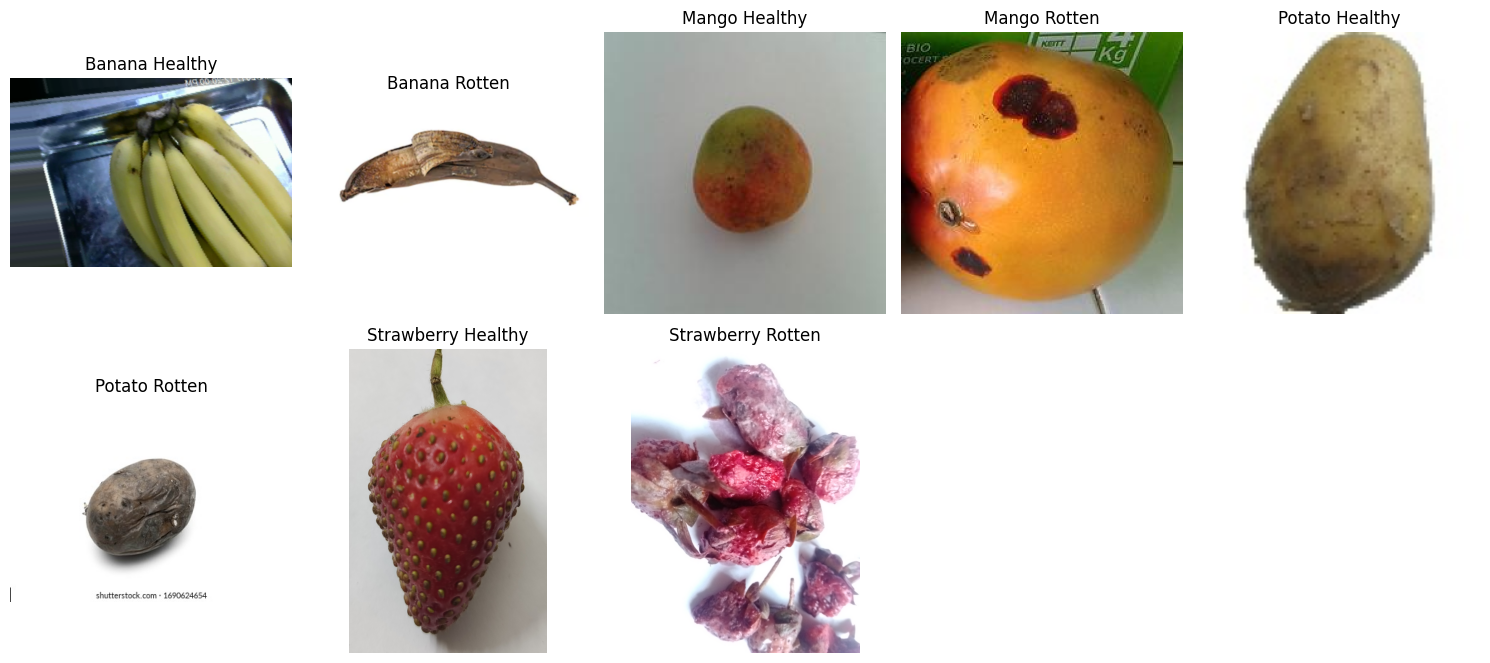

In [17]:
# Visualisasi 1 gambar dari masing-masing kelas setelah gambar augmentasi dari dataset dihapus
plt.figure(figsize=(15, 10))
for idx, class_name in enumerate(class_names[:15]):
    class_folder = os.path.join(data_dir, class_name)
    img_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    img = tf.keras.utils.load_img(img_path)
    plt.subplot(3, 5, idx+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

#**4. Preprocessing**#
Akan dilakukan split train-test-valid dengan pembagian 0.7 - 0.15 - 0.15

Kemudian akan dilakukan Augmentasi.

In [18]:
# === Preprocessing dan Split Dataset ===
all_filepaths = []
all_labels = []

for class_name in class_names:
    class_folder = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_folder):
        all_filepaths.append(os.path.join(class_folder, fname))
        all_labels.append(class_name)

X_train, X_temp, y_train, y_temp = train_test_split(all_filepaths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [19]:
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 7179 | Val: 1538 | Test: 1539


In [20]:
#filter file
def is_valid_image(path):
    try:
        tf.keras.utils.load_img(path)
        return True
    except:
        return False

# Filter data training
valid_indices = [i for i, path in enumerate(X_train) if is_valid_image(path)]
X_train = [X_train[i] for i in valid_indices]
y_train = [y_train[i] for i in valid_indices]

# Filter data validasi
valid_indices = [i for i, path in enumerate(X_val) if is_valid_image(path)]
X_val = [X_val[i] for i in valid_indices]
y_val = [y_val[i] for i in valid_indices]

# Filter data test
valid_indices = [i for i, path in enumerate(X_test) if is_valid_image(path)]
X_test = [X_test[i] for i in valid_indices]
y_test = [y_test[i] for i in valid_indices]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
# === ImageDataGenerator ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
def make_gen(X, y, datagen, shuffle=True):
    df = pd.DataFrame({"filename": X, "class": y})
    return datagen.flow_from_dataframe(
        df, x_col="filename", y_col="class",
        target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=shuffle
    )

train_gen = make_gen(X_train, y_train, train_datagen, shuffle=True)
val_gen   = make_gen(X_val,   y_val,   val_datagen, shuffle=False)
test_gen  = make_gen(X_test,  y_test,  val_datagen, shuffle=False)

Found 7175 validated image filenames belonging to 8 classes.
Found 1537 validated image filenames belonging to 8 classes.
Found 1538 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


#**5. Pembangunan Model**#
Akan digunakan Transfer Learning dengan menggunakan MobileNetV2 dengan pretrained model dengan weight imagenet yang difreeze kemudian akan dilatih dengan beberapa layer tambahan untuk melatihnya dengan dataset pada proyek ini.

In [39]:
# === Build Model ===
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
]

history_cnn = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,654,504 (10.13 MB)

 Trainable params: 396,520 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
 63/113 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2580 - loss: 2.1183

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3550 - loss: 1.8304 - val_accuracy: 0.8959 - val_loss: 0.3657
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8592 - loss: 0.4705 - val_accuracy: 0.9486 - val_loss: 0.1599
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9200 - loss: 0.2508 - val_accuracy: 0.9603 - val_loss: 0.1205
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9513 - loss: 0.1736 - val_accuracy: 0.9688 - val_loss: 0.1057
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9649 - loss: 0.1302 - val_accuracy: 0.9688 - val_loss: 0.1017
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9658 - loss: 0.1194 - val_accuracy: 0.9694 - val_loss: 0.0895
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9707 - loss: 0.0967 - val_accuracy: 0.9701 - val_loss: 0.0884
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9788 - loss: 0.0724 - val_accuracy: 0.975

In [40]:
train_loss, train_acc = model.evaluate(train_gen)
test_loss, test_acc = model.evaluate(test_gen)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

113/113 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9908 - loss: 0.0306
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.9820 - loss: 0.0565
Train Accuracy: 99.08%
Test Accuracy: 97.98%


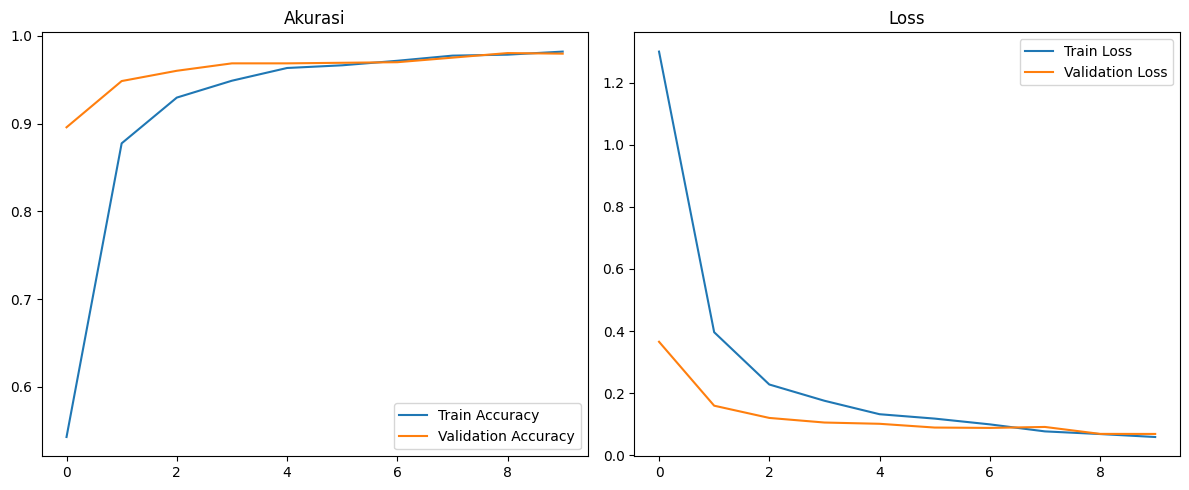

In [41]:
# === Plot Akurasi dan Loss ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Akurasi')

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.tight_layout()
plt.show()

#**6.  Export Model dan Inferensi**#
Model akan disave kemudian selanjutnya akan dilakukan inference dari data test, karena test tidak digunakan selama pelatihan, ketika pelatihan yang digunakan yaitu test dan val, oleh karena itu digunakan data test untuk melakukan inference model yang telah dilatih.

In [51]:
model.export('submission/saved_model', save_format='tf')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_482')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  135574726809104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726810064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726810448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726810256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726808528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726811600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726811984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726812368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726812176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574726809488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1355

In [67]:
!tensorflowjs_converter --input_format=tf_saved_model \
    submission/saved_model \
    submission/tfjs_model

2025-04-20 14:26:52.542398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745159212.562809   50973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745159212.568946   50973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-20 14:26:57.596403: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745159217.596636   50973 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [53]:
# Konversi
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()
# Simpan
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
# Buat label.txt
with open('submission/tflite/label.txt', 'w') as f:
    f.write("\n".join(sorted(class_names)))

In [87]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path='submission/tflite/model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi prediksi satu gambar
def predict_tflite(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype('float32')

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    class_idx = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    predicted_label = sorted(class_names)[class_idx]
    return predicted_label, confidence

# Lakukan prediksi untuk 7 data uji dan bandingkan dengan label aslinya
for i in range(7):
    img_path = X_test[i]
    true_label = y_test[i]
    predicted_label, confidence = predict_tflite(img_path)
    print(f"Image Path         : {img_path}")
    print(f"Predicted Class    : {predicted_label} ({confidence*100:.2f}%)")
    print(f"Label Sesungguhnya : {true_label}\n")

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Mango Rotten/anthracnose_045.jpg
Predicted Class    : Mango Rotten (98.81%)
Label Sesungguhnya : Mango Rotten

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Mango Healthy/869.jpg
Predicted Class    : Mango Healthy (99.96%)
Label Sesungguhnya : Mango Healthy

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Potato Rotten/rottenPotato (257).jpg
Predicted Class    : Potato Rotten (99.58%)
Label Sesungguhnya : Potato Rotten

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Mango Rotten/977.jpg
Predicted Class    : Mango Rotten (100.00%)
Label Sesungguhnya : Mango Rotten

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Strawberry Rotten/568.jpg
Predicted Class    : Strawberry Rotten (100.00%)
Label Sesungguhnya : Strawberry Rotten

Image Path         : /content/Fruit And Vegetable Diseases Dataset/Strawberry Healthy/freshStrawberry (205).jpg
Predicte

In [88]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.14.0.37.22
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confe